<a href="https://colab.research.google.com/github/farrelrassya/PracticalMachineLearningforComputerVision/blob/main/02_ML_Model_for_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this chapter, you will learn how to represent images and train basic machine learning models to classify images. You will discover that the performance of linear and fully connected neural networks is poor on images. However, along the way, you will learn how to use the Keras API to implement ML primitives and train ML models.

## A Dataset for Machine Perception
For the purposes of this book, it will be helpful if we take a single practical problem
and build a variety of machine learning models to solve it. Assume that we have collected and labeled a dataset of nearly four thousand photographs of flowers. There are five types of flowers in the 5-flowers dataset (see Figure 2-1), and each image in the dataset has already been labeled with the type of flower it depicts.

Suppose we want to create a computer program that will, when provided an image,
tell us what type of flower is in the image. We are asking the machine learning model to learn to perceive what’s in the image, so you might see this type of task called machine perception. Specifically, the type of perception is analogous to human sight,so the problem is termed computer vision, and in this case we will solve it through image classification.

In [1]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.17.1
Found GPU at: /device:GPU:0


In [2]:
!gsutil cat gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/train_set.csv | head -20

gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg,daisy
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/18089878729_907ed2c7cd_m.jpg,dandelion
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/284497199_93a01f48f6.jpg,dandelion
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg,dandelion
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/daisy/4065883015_4bb6010cb7_n.jpg,daisy
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/roses/7420699022_60fa574524_m.jpg,roses
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/4558536575_d43a611bd4_n.jpg,dandelion
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/daisy/7568630428_8cf0fc16ff_n.jpg,daisy
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/7064813645_f7f48fb527.jpg,tulips
gs://practical-ml-vision-book-data/

In [3]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
def read_and_decode(filename, reshape_dims):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)

CLASS_NAMES = [item.numpy().decode("utf-8") for item in
               tf.strings.regex_replace(
                 tf.io.gfile.glob("gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/*"),
                 "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/", "")]
CLASS_NAMES = [item for item in CLASS_NAMES if item.find(".") == -1]
print("These are the available classes:", CLASS_NAMES)

These are the available classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


Always visualize a few of the images to ensure that you are reading the data correctly a common mistake is to read the data in such a way that the images are rotated or mirrored. Visualizing the images is also useful to get a sense of how challenging a machine perception problem is. We can use Matplotlib’s imshow() function to visualize an image, but in order to do so we must first convert the image, which is a TensorFlow tensor, into a numpy array
using the numpy() function.

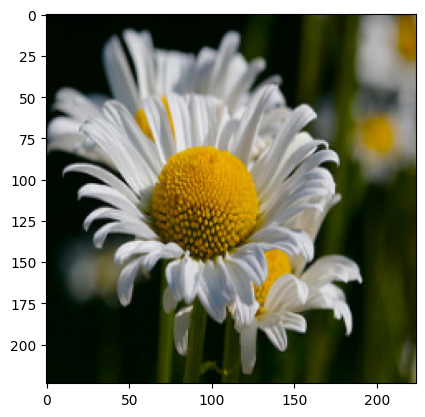

In [4]:
# Try reading and displaying one of the files
def show_image(filename):
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  plt.imshow((img.numpy()));

show_image(
    "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg")

We now know how to read an image. In order to train a machine model, though, we
need to read many images. We also have to obtain the labels for each of the images.
We could obtain a list of all the images by carrying out a wildcard match using
glob():

gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/100930342_92e8746431_n.jpg
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/10094729603_eeca3f2cb6.jpg
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/10094731133_94a942463c.jpg
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/10128546863_8de70c610d.jpg
gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/10163955604_ae0b830975_n.jpg


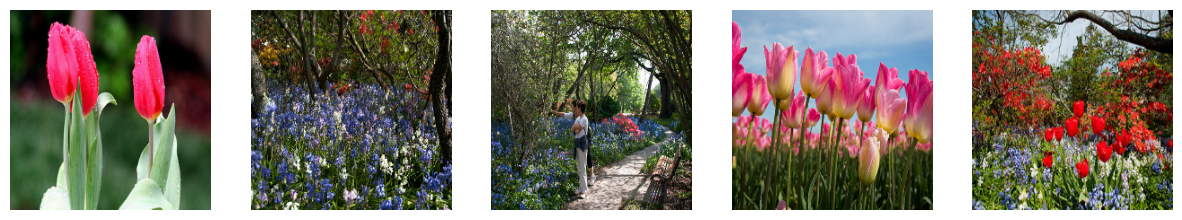

In [5]:
# notice that the file name has the flower type in it. Let's look at a few tulips
tulips = tf.io.gfile.glob("gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/*.jpg")
f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, filename in enumerate(tulips[:5]):
  print(filename)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  ax[idx].imshow((img.numpy()));
  ax[idx].axis('off')

In [6]:
tf.strings.split(tf.strings.regex_replace(
    "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/10094731133_94a942463c.jpg",
    "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/", ""),
    '/')[0]

<tf.Tensor: shape=(), dtype=string, numpy=b'tulips'>

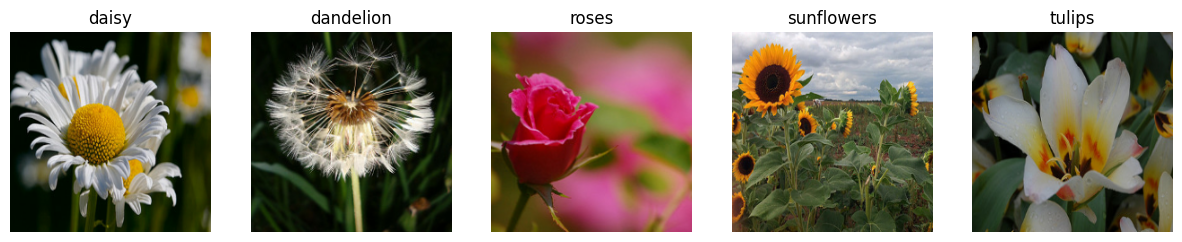

In [7]:
f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, filename in enumerate([
  "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg",
  "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg",
  "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/roses/7420699022_60fa574524_m.jpg",
  "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/sunflowers/21518663809_3d69f5b995_n.jpg",
  "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/tulips/8713398906_28e59a225a_n.jpg"
]):
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  ax[idx].imshow((img.numpy()));
  ax[idx].set_title(CLASS_NAMES[idx])
  ax[idx].axis('off')

In [8]:
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  # label = tf.math.equal(CLASS_NAMES, label_string)
  return img, label_string

dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/train_set.csv").
    map(decode_csv))

for img, label in dataset.take(3):
  avg = tf.math.reduce_mean(img, axis=[0, 1]) # average pixel in the image
  print(label, avg)

tf.Tensor(b'daisy', shape=(), dtype=string) tf.Tensor([0.3588961  0.36257887 0.26933077], shape=(3,), dtype=float32)
tf.Tensor(b'dandelion', shape=(), dtype=string) tf.Tensor([0.32278517 0.32278517 0.32278517], shape=(3,), dtype=float32)
tf.Tensor(b'dandelion', shape=(), dtype=string) tf.Tensor([0.20397592 0.13298093 0.07217225], shape=(3,), dtype=float32)


In [9]:
class Centroid:
  def __init__(self, label):
    self.label = label
    self.sum_so_far = tf.constant(0., dtype=tf.float32)
    self.count_so_far = 0

  def update(self, value):
    self.sum_so_far = self.sum_so_far + value
    self.count_so_far = self.count_so_far + 1
    if self.count_so_far%100 == 0:
      print(self.label, self.count_so_far)

  def centroid(self):
    return self.sum_so_far / self.count_so_far

  def __str__(self):
    return '{} {}'.format(self.label, self.centroid().numpy())


class CentroidRule:
  def __init__(self):
    self.centroids = {
        f: Centroid(f) for f in CLASS_NAMES}

  def fit(self, dataset):
    for img, label in dataset:
      label = label.numpy().decode("utf-8")
      avg = tf.reduce_mean(img, axis=[0, 1]) # average pixel in the image
      self.centroids[label].update(avg)

  def predict(self, img):
    avg = tf.reduce_mean(img, axis=[0, 1]) # average pixel in the image
    best_label = ""
    best_diff = 999
    for key, val in self.centroids.items():
      diff = tf.reduce_sum(tf.abs(avg - val.centroid()))
      if diff < best_diff:
        best_diff = best_diff
        best_label = key
    return best_label

  def evaluate(self, dataset):
    num_correct, total_images = 0, 0
    for img, label in dataset:
      correct = label.numpy().decode('utf-8')
      predicted = self.predict(img)
      if correct == predicted:
        num_correct = num_correct + 1
      total_images = total_images + 1
    accuracy = num_correct / total_images
    return(accuracy)

In [10]:
rule = CentroidRule()

# to try it on the full dataset, remove the .take(500)
train_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/train_set.csv").
    map(decode_csv)).take(500)

eval_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/eval_set.csv").
    map(decode_csv)).take(50)

rule.fit(train_dataset)

# There is not much separation between the classes
print(rule.centroids['daisy'])
print(rule.centroids['roses'])

# let's evaluate it
rule.evaluate(eval_dataset)

dandelion 100
tulips 100
daisy [0.44554377 0.44968468 0.3594977 ]
roses [0.46776444 0.37675467 0.31471127]


0.24

In [11]:
# this is how you'd use the model to predict
filename = "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg"
img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
pred = rule.predict(img)
print(pred)

tulips


In [12]:
# decode_csv changed so that the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

train_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/train_set.csv").
    map(decode_csv)).batch(10)

eval_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/eval_set.csv").
    map(decode_csv)).batch(10)

# linear model
model = tf.keras.Sequential([
              tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
              tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 150528)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │         752,645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 752,645 (2.87 MB)

 Trainable params: 752,645 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

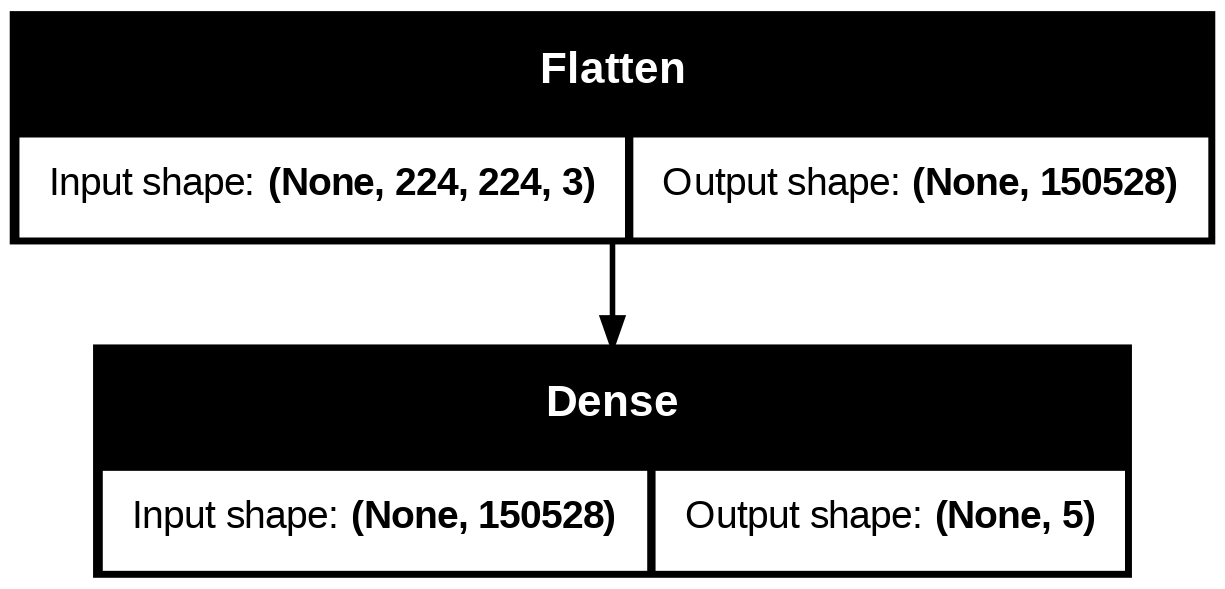

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [15]:
history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)

Epoch 1/10
    330/Unknown 305s 918ms/step - accuracy: 0.3087 - loss: 19.0946

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


330/330 ━━━━━━━━━━━━━━━━━━━━ 338s 1s/step - accuracy: 0.3088 - loss: 19.0886 - val_accuracy: 0.4027 - val_loss: 25.0346
Epoch 2/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 322s 842ms/step - accuracy: 0.4064 - loss: 14.7841 - val_accuracy: 0.3351 - val_loss: 26.0555
Epoch 3/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 256s 643ms/step - accuracy: 0.4541 - loss: 14.0804 - val_accuracy: 0.3378 - val_loss: 33.9229
Epoch 4/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 236s 565ms/step - accuracy: 0.4904 - loss: 13.7250 - val_accuracy: 0.3541 - val_loss: 25.5861
Epoch 5/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 194s 541ms/step - accuracy: 0.5217 - loss: 10.2528 - val_accuracy: 0.3757 - val_loss: 32.2456
Epoch 6/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 184s 487ms/step - accuracy: 0.5304 - loss: 12.5427 - val_accuracy: 0.3486 - val_loss: 30.5426
Epoch 7/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 197s 472ms/step - accuracy: 0.5396 - loss: 12.7968 - val_accuracy: 0.4189 - val_loss: 22.6928
Epoch 8/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 191s 438ms/step - accuracy: 0.5224 -

In [16]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(15,5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric])
        ax[idx].set_xlabel("Epochs")
        # ax[idx].set_ylabel(metric, fontweight='bold', fontsize=20)
        ax[idx].plot(history.history['val_' + metric], ls='dashed');
        ax[idx].legend([metric, 'val_' + metric], fontsize=20)

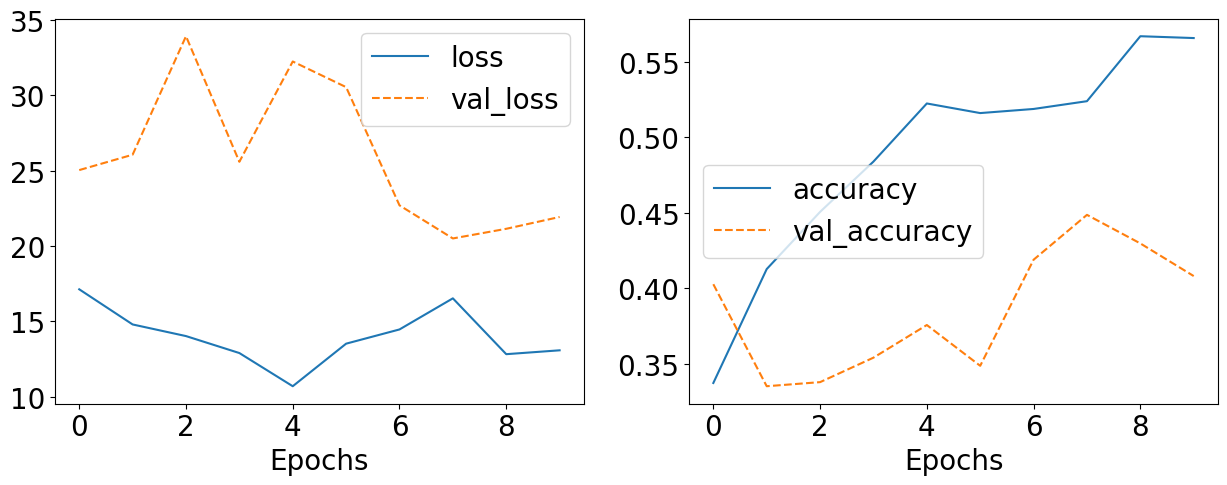

In [17]:
training_plot(['loss', 'accuracy'], history);

[0.09405971 0.0570501  0.8488902 ]
[0.04838872 0.0721875  0.8794238 ]


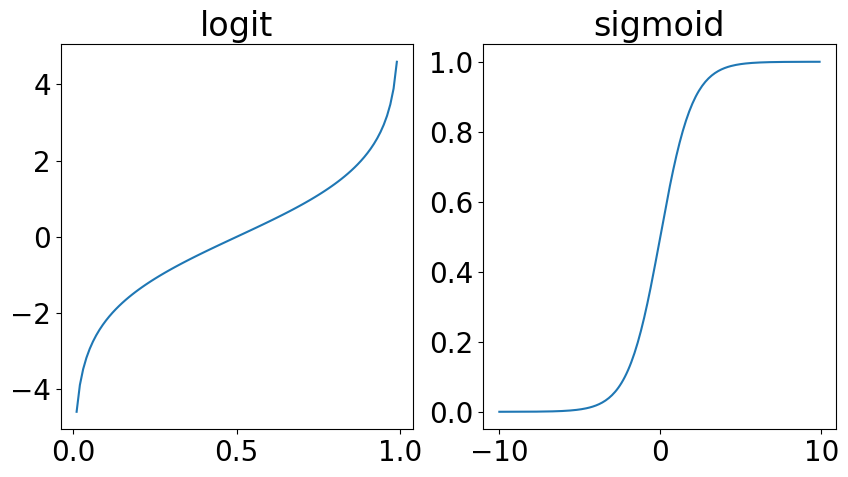

In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt

fig, ax = plt.subplots(1, 2, figsize=(10,5))
x = np.arange(0.01, 1.0, 0.01)
y = np.log(x / (1-x))
ax[0].plot(x, y)
ax[0].set_title("logit")
x = np.arange(-10.0, 10.0, 0.1)
y = tf.math.sigmoid(x)
ax[1].plot(x, y);
ax[1].set_title("sigmoid")

print( tf.math.softmax([-1.0, -1.5, 1.2]).numpy() )
print( tf.math.softmax([0.1, 0.5, 3.0]).numpy() )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


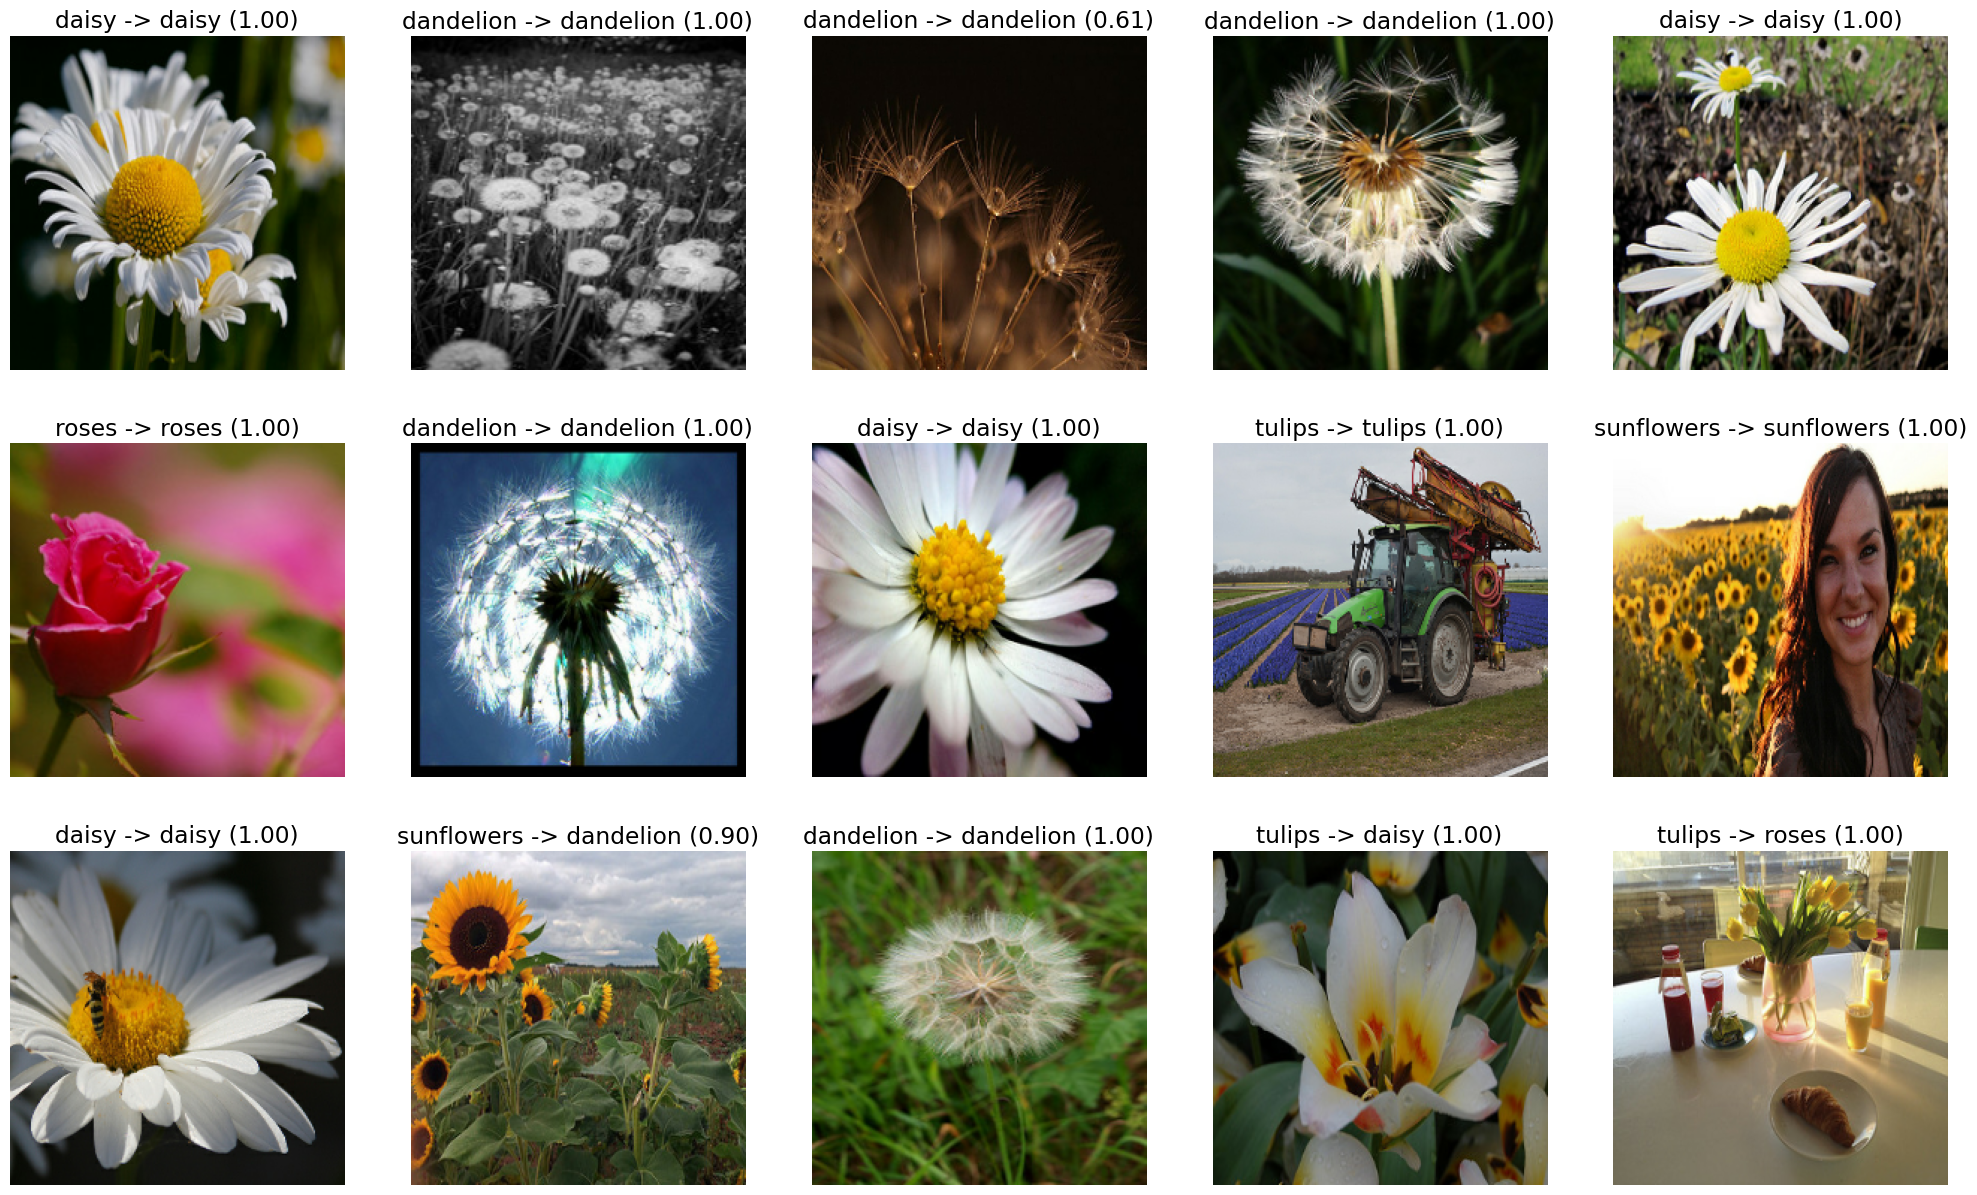

In [19]:
# Call model.predict() on a few images in the evaluation dataset
def plot_predictions(filename):
  matplotlib.rcParams.update({'font.size': 14})
  f, ax = plt.subplots(3, 5, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{} -> {} ({:.2f})'.format(label, pred_label, prob))
    ax[idx//5, idx%5].axis('off')

plot_predictions("gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/train_set.csv")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


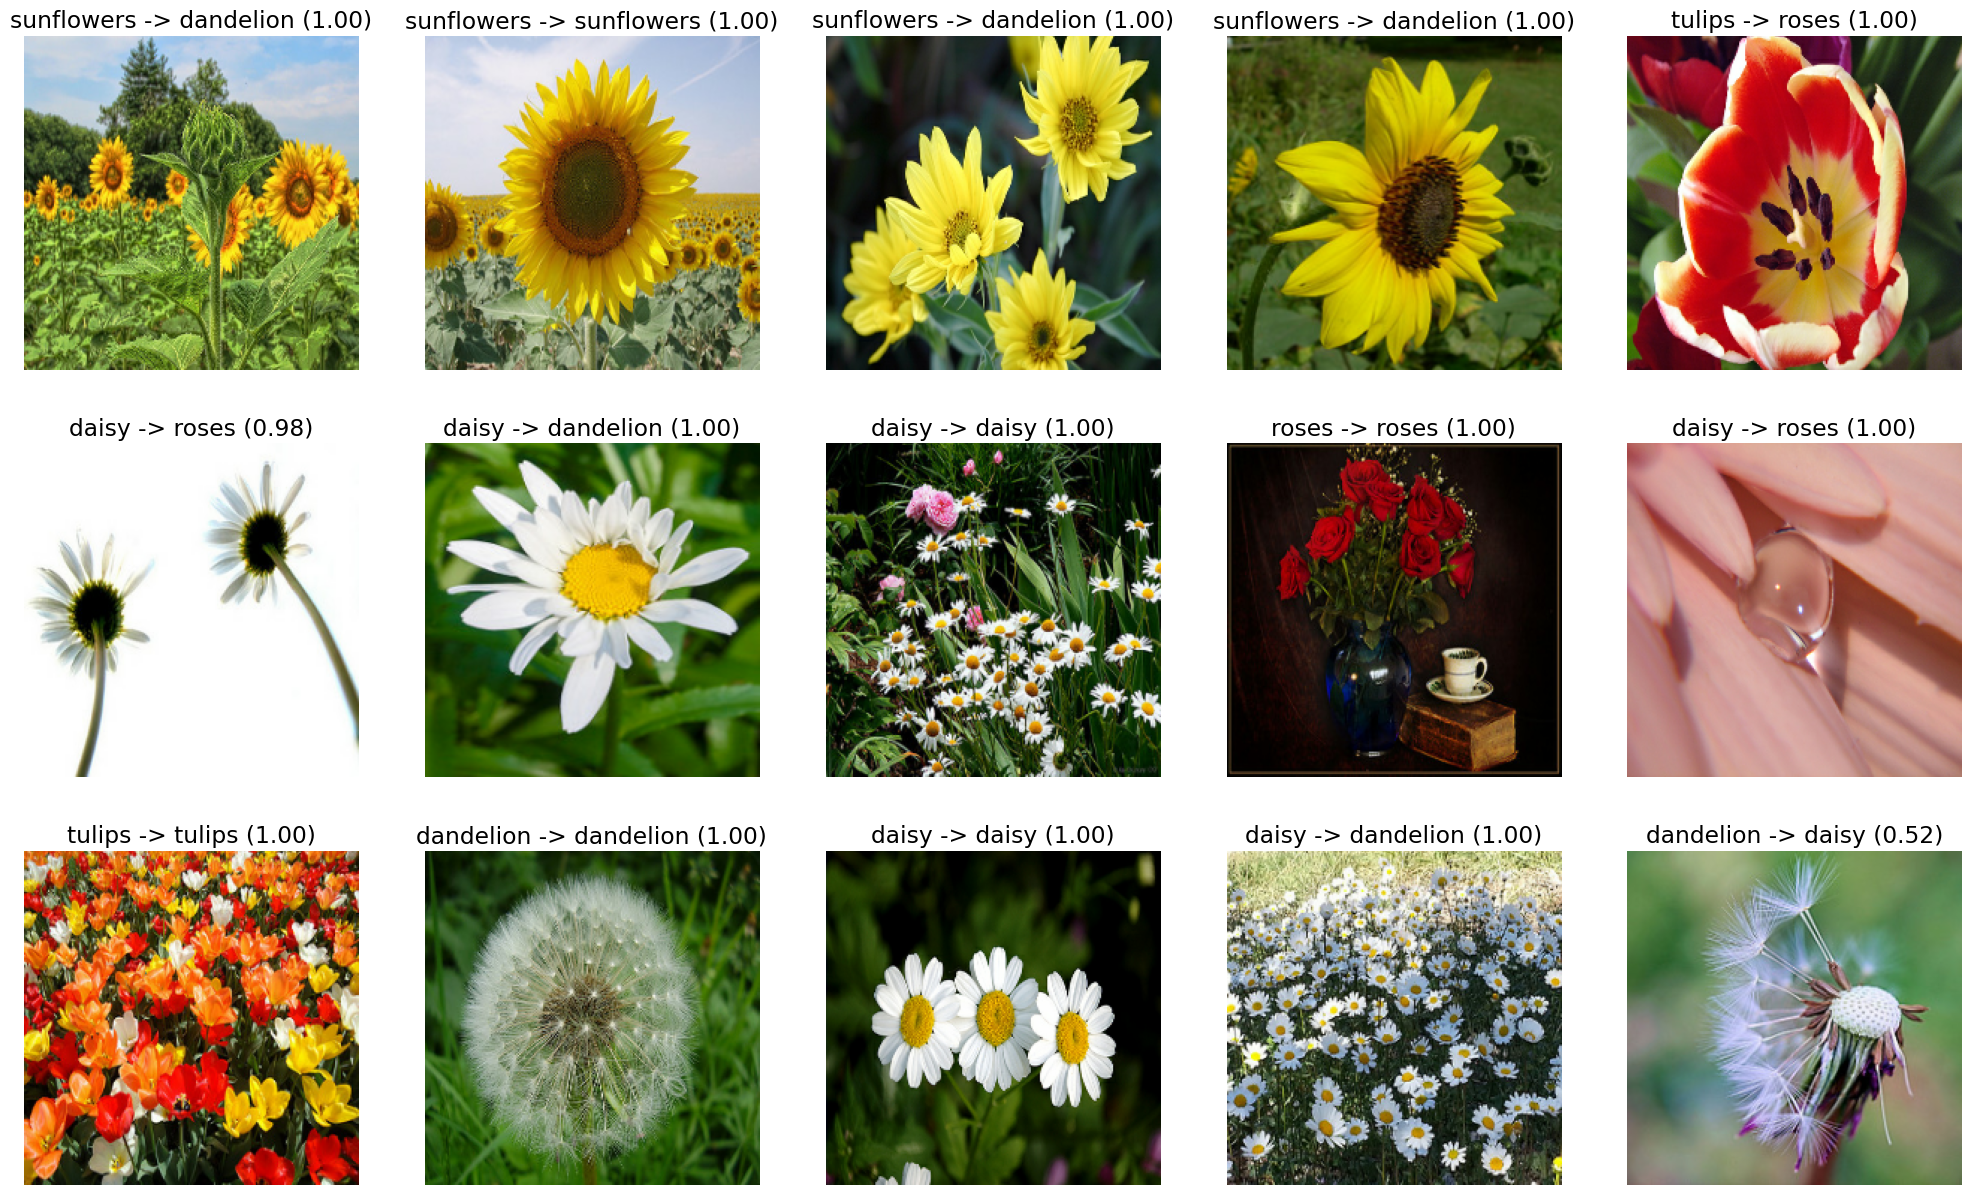

In [20]:
plot_predictions("gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/eval_set.csv")

Scaling weights for daisy in -0.14810945093631744 to 0.1268976777791977
Scaling weights for dandelion in -0.12032539397478104 to 0.15871983766555786
Scaling weights for roses in -0.10481471568346024 to 0.12209347635507584
Scaling weights for sunflowers in -0.16378948092460632 to 0.12133398652076721
Scaling weights for tulips in -0.11545618623495102 to 0.1140172928571701


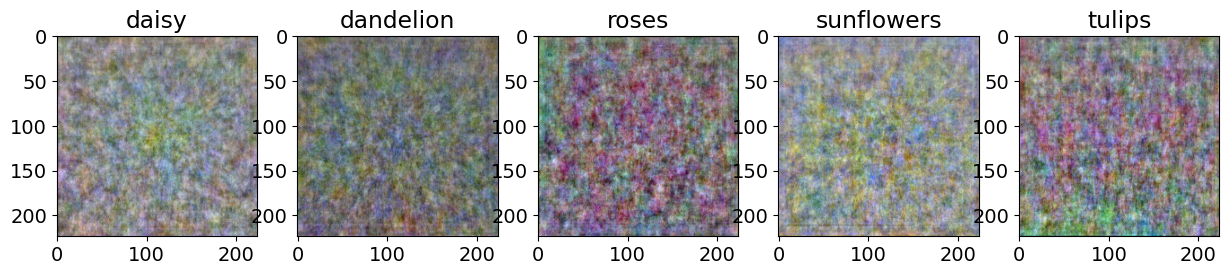

In [21]:
def show_trained_weights(model):
  # CLASS_NAMES is ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
  LAYER = 1 # Layer 0 flattens the image, layer=1 is the first dense layer
  WEIGHT_TYPE = 0 # 0 for weight, 1 for bias

  f, ax = plt.subplots(1, 5, figsize=(15,15))
  for flower in range(len(CLASS_NAMES)):
    weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
    min_wt = tf.math.reduce_min(weights).numpy()
    max_wt = tf.math.reduce_max(weights).numpy()
    flower_name = CLASS_NAMES[flower]
    print("Scaling weights for {} in {} to {}".format(
        flower_name, min_wt, max_wt))
    weights = (weights - min_wt)/(max_wt - min_wt)
    ax[flower].imshow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, 3));
    ax[flower].set_title(flower_name);

show_trained_weights(model)

[0.   0.09 0.06 0.85 0.  ] [0.         0.01696592 0.01094963 0.9720845  0.        ]
[0.09090909 0.09090909 0.6363636  0.09090909 0.09090909] [0.04651164 0.04651164 0.8139535  0.04651164 0.04651164]
[0.   0.25 0.5  0.25 0.  ] [0.        0.2       0.6000001 0.2       0.       ]
[0.08333333 0.08333333 0.3333333  0.41666666 0.08333333] [0.06113537 0.06113537 0.33624452 0.48034936 0.06113537]
[0.125 0.125 0.5   0.125 0.125] [0.09090909 0.09090909 0.6363636  0.09090909 0.09090909]


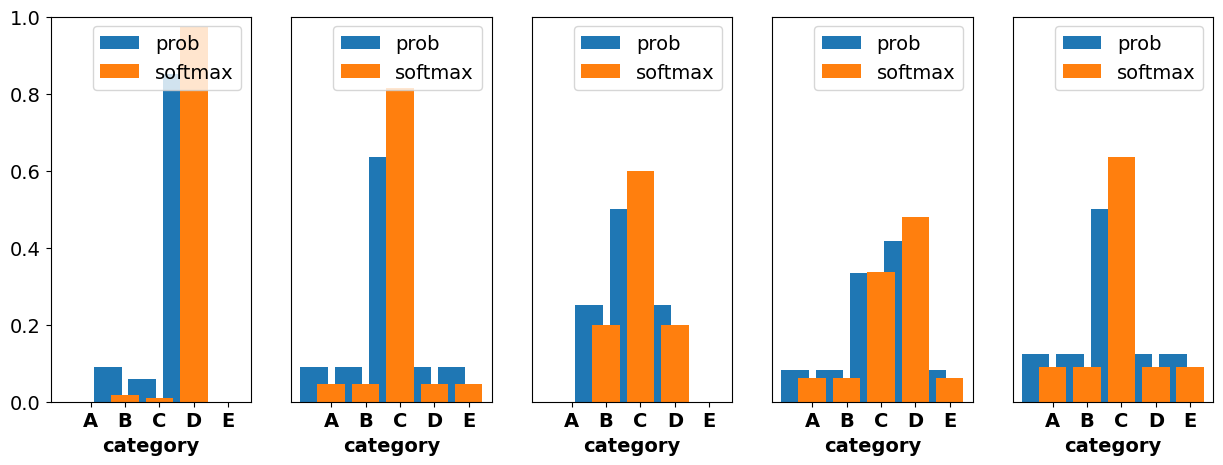

In [22]:
import tensorflow as tf

inx = [
    [0, 0.09, 0.06, 0.85, 0],
    [0.1, 0.1, 0.7, 0.1, 0.1],
    [0, 0.2, 0.4, 0.2, 0],
    [0.1, 0.1, 0.4, 0.5, 0.1],
    [0.2, 0.2, 0.8, 0.2, 0.2],
]

def logit(x):
    return - tf.math.log(1. / x - 1.)

barWidth = 0.5
r1 = np.arange(len(inx[0]))
r2 = [x + barWidth for x in r1]

f, ax = plt.subplots(1, 5, figsize=(15,5))
for idx, x in enumerate(inx):
    prob = x / tf.reduce_sum(x)
    softmax = tf.nn.softmax(logit(prob))
    print(prob.numpy(), softmax.numpy())
    ax[idx].bar(r1, prob, label='prob')
    ax[idx].bar(r2, softmax, label='softmax')
    ax[idx].set_xlabel('category', fontweight='bold')
    ax[idx].set_xticks(r2)
    ax[idx].set_xticklabels(['A','B','C','D','E'], fontweight='bold')
    ax[idx].set_ylim([0,1])
    if idx > 0:
        ax[idx].yaxis.set_visible(False)
    ax[idx].legend()